0:	learn: 0.6491945	total: 49.4ms	remaining: 49.4s
200:	learn: 0.1111767	total: 579ms	remaining: 2.3s
400:	learn: 0.0384454	total: 1.01s	remaining: 1.5s
600:	learn: 0.0188233	total: 1.46s	remaining: 967ms
800:	learn: 0.0115950	total: 1.89s	remaining: 468ms
999:	learn: 0.0083177	total: 2.3s	remaining: 0us
Accuracy: 80.45%


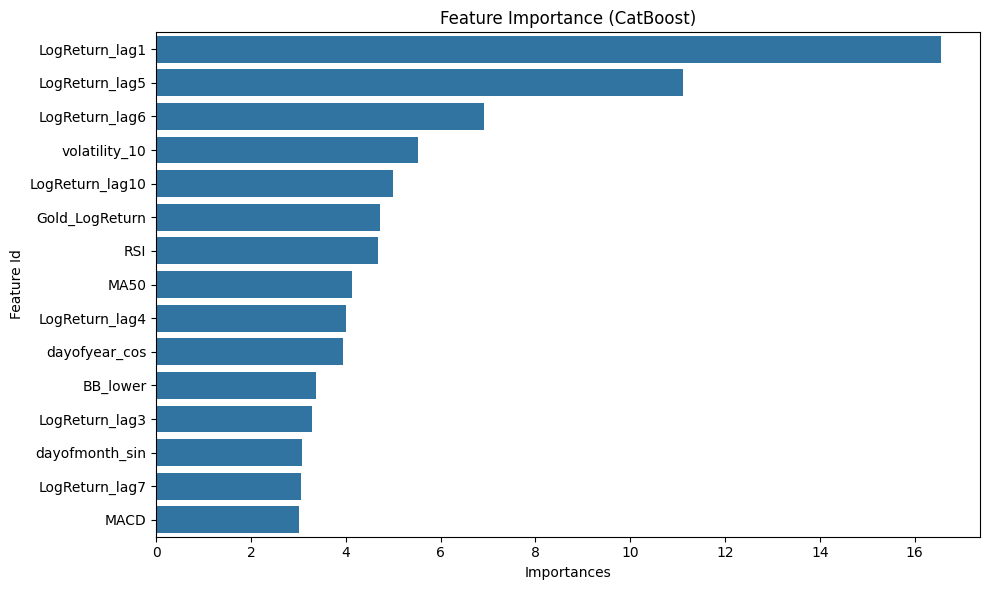

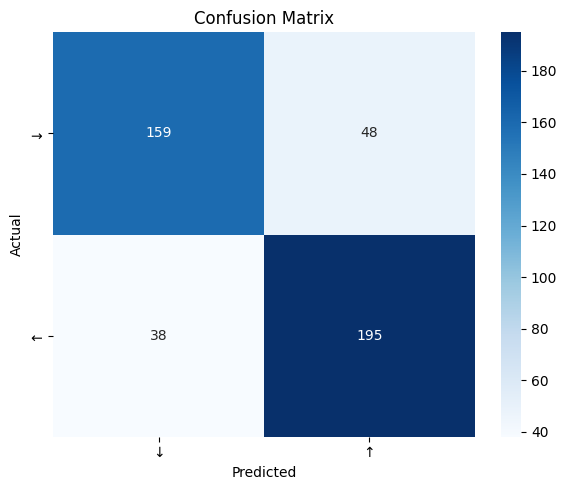

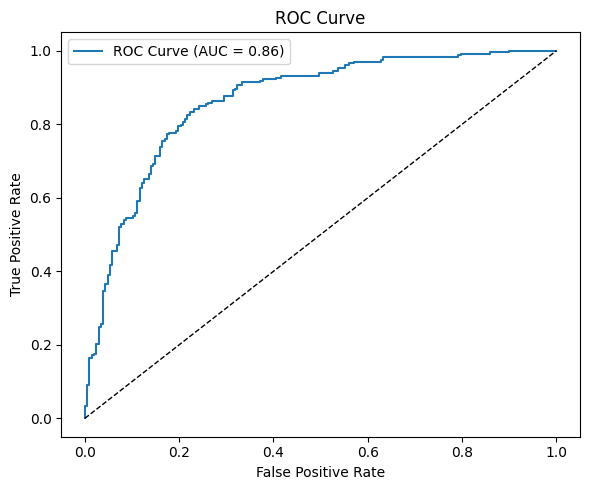

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       207
           1       0.80      0.84      0.82       233

    accuracy                           0.80       440
   macro avg       0.80      0.80      0.80       440
weighted avg       0.80      0.80      0.80       440



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Wczytanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Przekształcenie 'LogReturn' do wartości binarnych
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)

# Przygotowanie X i Y
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Inicjalizacja i trening modelu
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=200)
model.fit(X_train, y_train)

# Predykcje
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Dokładność
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# === FEATURE IMPORTANCE ===
feature_importance = model.get_feature_importance(prettified=True)
top15 = feature_importance.sort_values(by='Importances', ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=top15.sort_values(by='Importances', ascending=False))
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

# === CONFUSION MATRIX ===
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['↓', '↑'], yticklabels=['↓', '↑'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === ROC CURVE + AUC ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Oblicz metryki
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # domyślnie dla klasy pozytywnej (1)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Wyświetl metryki
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")
print(f"F1-Score : {f1 * 100:.2f}%")


Accuracy : 80.45%
Precision: 80.25%
Recall   : 83.69%
F1-Score : 81.93%


0:	learn: 1.3342473	total: 8.25ms	remaining: 8.24s
200:	learn: 0.5222309	total: 1.06s	remaining: 4.21s
400:	learn: 0.3039467	total: 2.19s	remaining: 3.27s
600:	learn: 0.1984878	total: 3.28s	remaining: 2.18s
800:	learn: 0.1359711	total: 4.5s	remaining: 1.12s
999:	learn: 0.1001189	total: 5.61s	remaining: 0us

Accuracy : 57.73%
Precision: 57.67%
Recall   : 58.45%
F1-Score : 57.90%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       104
           1       0.53      0.44      0.48       125
           2       0.44      0.46      0.45       106
           3       0.64      0.70      0.67       105

    accuracy                           0.58       440
   macro avg       0.58      0.58      0.58       440
weighted avg       0.57      0.58      0.57       440



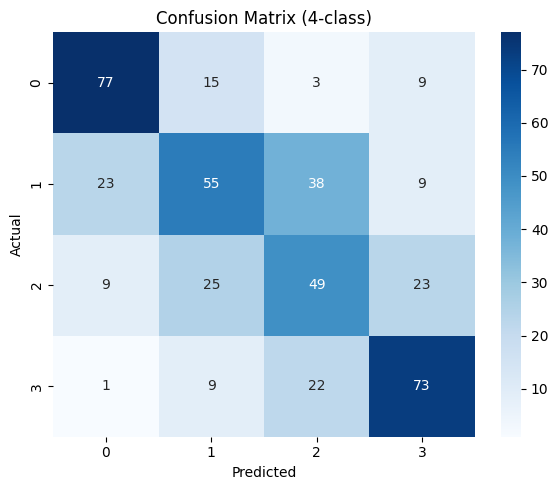

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)

# Wczytanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Obliczanie kwartylów
q1 = data['LogReturn'].quantile(0.25)
q2 = data['LogReturn'].quantile(0.50)
q3 = data['LogReturn'].quantile(0.75)

# Przekształcenie 'LogReturn' do 4 klas
data_class['LogReturn'] = pd.cut(data['LogReturn'], bins=[-float('inf'), q1, q2, q3, float('inf')],
                                 labels=[0, 1, 2, 3])

# Przygotowanie X i Y
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn'].astype(int)  # <- upewniamy się, że to liczby całkowite

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=200
)

# Trening
model.fit(X_train, y_train)

# Predykcje
y_pred = model.predict(X_test)

# === METRYKI ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nAccuracy : {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")
print(f"F1-Score : {f1 * 100:.2f}%")

# === Classification Report ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# === Macierz pomyłek ===
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (4-class)')
plt.tight_layout()
plt.show()


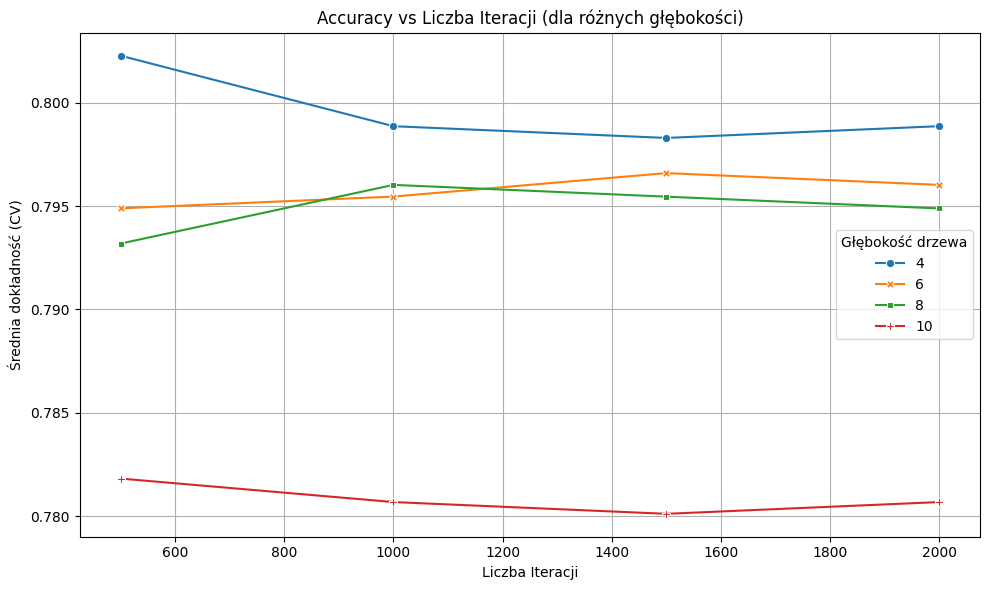

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Generowanie przykładowych danych (zamiast prawdziwych danych)
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Przekształcenie 'LogReturn' do wartości binarnych
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)

# Przygotowanie X i Y
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Siatka parametrów
param_grid = {
    'iterations': [500, 1000, 1500, 2000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.1]
}

# Inicjalizacja modelu
model = CatBoostClassifier(verbose=0, random_state=42)

# GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

# Wyniki do DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Wybór i przekształcenie danych do wizualizacji
pivot_table = results_df.pivot_table(values='mean_test_score', index='param_iterations', columns='param_depth')

# Wykres: Accuracy vs Iterations dla różnych głębokości
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_table, markers=True, dashes=False)
plt.title("Accuracy vs Liczba Iteracji (dla różnych głębokości)")
plt.xlabel("Liczba Iteracji")
plt.ylabel("Średnia dokładność (CV)")
plt.legend(title="Głębokość drzewa")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
from catboost import CatBoostClassifier
from catboost.utils import plot_tree

# Wyciągnięcie najlepszych parametrów
best_params = grid.best_params_

# Trenowanie modelu z najlepszymi parametrami
best_model = CatBoostClassifier(
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    verbose=0,
    random_state=42
)
best_model.fit(X_train, y_train)

# Poprawne wywołanie funkcji do wizualizacji drzewa
plot_tree(best_model, tree_idx=0)


ImportError: cannot import name 'plot_tree' from 'catboost.utils' (/home/codespace/.python/current/lib/python3.12/site-packages/catboost/utils.py)